In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import random
import os

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def redshift_to_snap(redshift):
    correspondense = {6:'sn013', 8:'sn008', 10:'sn004'}
    return correspondense[redshift]

In [3]:
def copy_halos(df):
    edges = 10**np.linspace(6.0 ,11., 51)
    halos_used = {6:[],8:[],10:[]}
    for i in range(len(edges)-1):
        sub_IDs = df[(edges[i]<df['StarMass']) & (df['StarMass']<edges[i+1])][['ID', 'z']]
        sub_IDs.reset_index(inplace=True)
        if len(sub_IDs)>0:
            if len(sub_IDs)>1:
                index = np.random.randint(0,len(sub_IDs)-1)
            else:
                index=0
            ID = sub_IDs.iloc[index]['ID']
            z = sub_IDs.iloc[index]['z']
            halos_used[z].append(ID)
            snap = redshift_to_snap(z)
            from_path, to_path = get_paths(ID,snap)
            os.system(f'cp -lr {from_path} {to_path}')
            print(f'Copied {from_path} to {to_path}')
    for key in halos_used:
        base_path = '/ptmp/mpa/mglatzle/TNG_f_esc'
        to_path = os.path.join(base_path, 'numerical_1e4', 'input', 'L35n2160TNG', redshift_to_snap(key))
        selected_halos_path = os.path.join(to_path, 'selected_halos') 
        np.save(selected_halos_path, halos_used[key])
    return

In [4]:
def update_df(df, h=0.6774):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']
    return

In [5]:
def get_paths(ID, snap):
    base_path = '/ptmp/mpa/mglatzle/TNG_f_esc'
    fid_path = os.path.join(base_path, 'fid2')
    numerical_path = os.path.join(base_path, 'numerical_1e4')
    input_path = f'input/L35n2160TNG/{snap}'
    
    origin_path = os.path.join(fid_path, input_path)
    from_path = os.path.join(origin_path, f'g{ID}')
    to_path = os.path.join(numerical_path, input_path)
    return from_path, to_path

In [47]:
def plot_num_comparison(comparison_df, x_prop='StarMass', save=False):
    h=0.6774
    x_labelsize = 50
    y_labelsize = 50

    length_major_ticks = 16
    length_minor_ticks = 8
    width_minor_ticks = 3
    width_major_ticks = 4
    labelsize_x_ticks = 35
    labelsize_y_ticks = 35
    legendsize = 50

    markersize = 280
    colorbar_labelsize = 50
    colorbar_ticklabelsize = 35

    axes_width = 3

    figure_width = 20
    figure_height = 20

    if x_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
        mult = 1e10/h
    elif x_prop == 'StarMass':
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
        mult=1.0

    y_label = '$f_\mathrm{esc}$'

    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e4'], label=r'$10^4$', marker='x', s=markersize)
    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e5'], label=r'$10^5$', marker='+', s=markersize)
    plt.scatter(np.log10(comparison_df[x_prop]*mult), comparison_df['f_esc_1e6'], label=r'$10^6$', marker='1', s=markersize)
    plt.yscale('log')
    plt.legend(fontsize=legendsize)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=labelsize_x_ticks) 
    plt.rc('ytick', labelsize=labelsize_y_ticks) 
    plt.xlabel(x_label, size=x_labelsize)
    plt.ylabel(y_label, size=y_labelsize)

    plt.rcParams["figure.figsize"] = (figure_width,figure_height)
    plt.tight_layout(rect=(0,0,1,0.7))
    if save:
        filename = f'/u/ivkos/analysis/plots/{x_prop}_numerical_test.pdf'
        plt.savefig(filename, bbox_inches = 'tight')
    plt.show();
    return

In [53]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3, y_axis='f_esc'):
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    error = []
    centers = []
    variance = []
    frac_small_arr = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][y_axis]
        
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            means.append(sub_fesc.mean())
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        frac_small_arr.append((sub_fesc < threshhold).sum()/len(sub_fesc))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84)
    error = np.array(error) 
    centers = np.array(centers)
    variance = np.array(variance)
    frac_small_arr = np.array(frac_small_arr)
        
    return centers, means, quantile16, quantile84, error, variance, frac_small_arr

In [82]:
def plot_tng_comparison(dfs, halo_prop='StarMass', bins=30, mode='median', y_threshold=1e-3, save=False):
        
    redshifts = [6,8,10]
    
    linewidth = 6
    markersize = 260
    markersize_scat = 60

    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    lower_y_threshold_log = y_threshold
    
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 35
    
    results = {}
    results['tng'] = {}
    results['tng2'] = {} 
    results['tng3'] = {}
    
    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    y_label = '$f_\mathrm{esc}$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    centers_tng, means_tng, *_ = get_scatter(dfs['tng'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')
    centers_tng2, means_tng2, *_ = get_scatter(dfs['tng2'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')
    centers_tng3, means_tng3, *_ = get_scatter(dfs['tng3'], halo_prop=halo_prop, bins=bins, 
                                               mode=mode, y_axis='f_esc')

    results['tng']['x'] = centers_tng
    results['tng']['y'] = means_tng

    results['tng2']['x'] = centers_tng2
    results['tng2']['y'] = means_tng2

    results['tng3']['x'] = centers_tng3
    results['tng3']['y'] = means_tng3
    
    f = plt.figure()
    ax1 = plt.subplot()

    x_values_dust = np.log10(results['tng']['x'])
    y_values_dust = results['tng']['y']
    #ax1.plot(x_values_dust, y_values_dust, linewidth=linewidth,  color='red', marker='+', label=r'dust')
    ax1.scatter(x_values_dust, y_values_dust, color='red', marker='+', s=markersize, label=r'TNG50')

    x_values_no_dust = np.log10(results['tng2']['x'])
    y_values_no_dust = results['tng2']['y']
    #ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', label=r'no dust')
    ax1.scatter(x_values_no_dust, y_values_no_dust, color='blue', marker='x', s=markersize, label=r'TNG50-2')
    
    x_values_no_dust = np.log10(results['tng3']['x'])
    y_values_no_dust = results['tng3']['y']
    #ax1.plot(x_values_no_dust, y_values_no_dust, linewidth=linewidth,  color='blue', marker='x', linestyle='--', label=r'no dust')
    ax1.scatter(x_values_no_dust, y_values_no_dust, color='green', marker='1', s=markersize, label=r'TNG50-3')
            
    ax1.set_yscale('log')
    ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.set_ylabel(x_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        path = f'/u/ivkos/analysis/plots/tng_comparison_{halo_prop}.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [41]:
def update_df(df, h=0.6774):
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [6]:
df_1e4_full = pd.read_pickle('dfs/numerical_1e4.pickle')
df_1e6 = pd.read_pickle('dfs/numerical_1e6.pickle')
df = pd.read_pickle('dfs/fid2.pickle')

In [43]:
merge_1 = df.merge(df_1e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
comparison_df = merge_1.merge(df_1e4_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e4'] = comparison_df['f_esc']
update_df(comparison_df)

In [63]:
df_tng2 = pd.read_pickle('dfs/TNG50_2.pickle')
update_df(df_tng2)
df_tng3 = pd.read_pickle('dfs/TNG50_3.pickle')
update_df(df_tng3)
update_df(df)

In [64]:
dfs = {}
dfs['tng'] = df
dfs['tng2'] = df_tng2
dfs['tng3'] = df_tng3

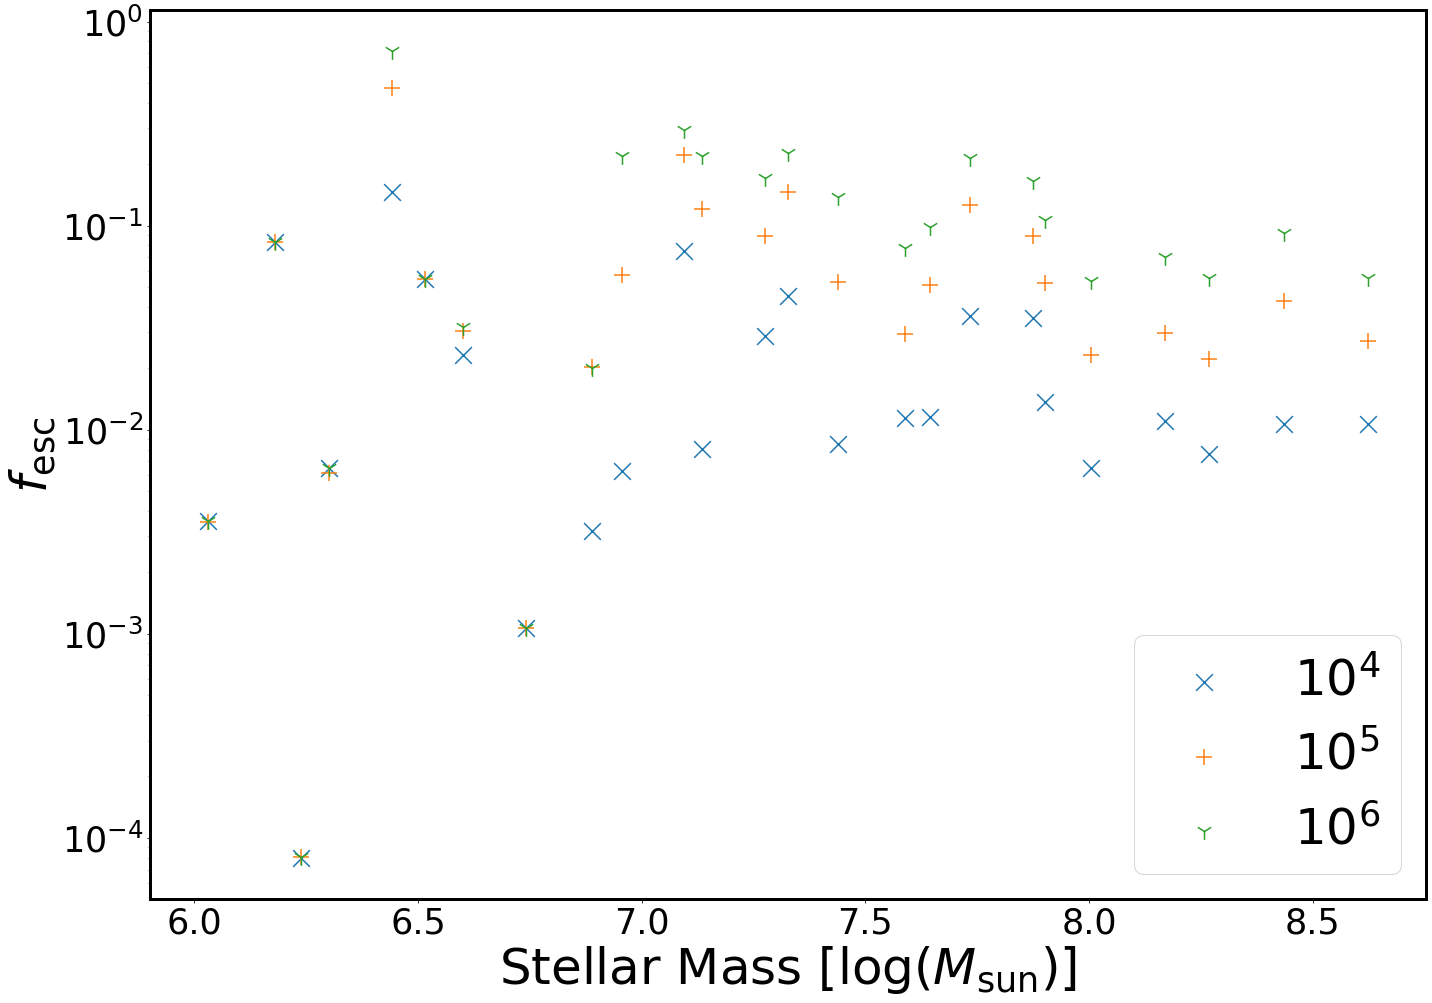

In [65]:
plot_num_comparison(comparison_df=comparison_df, x_prop='StarMass', save=True)

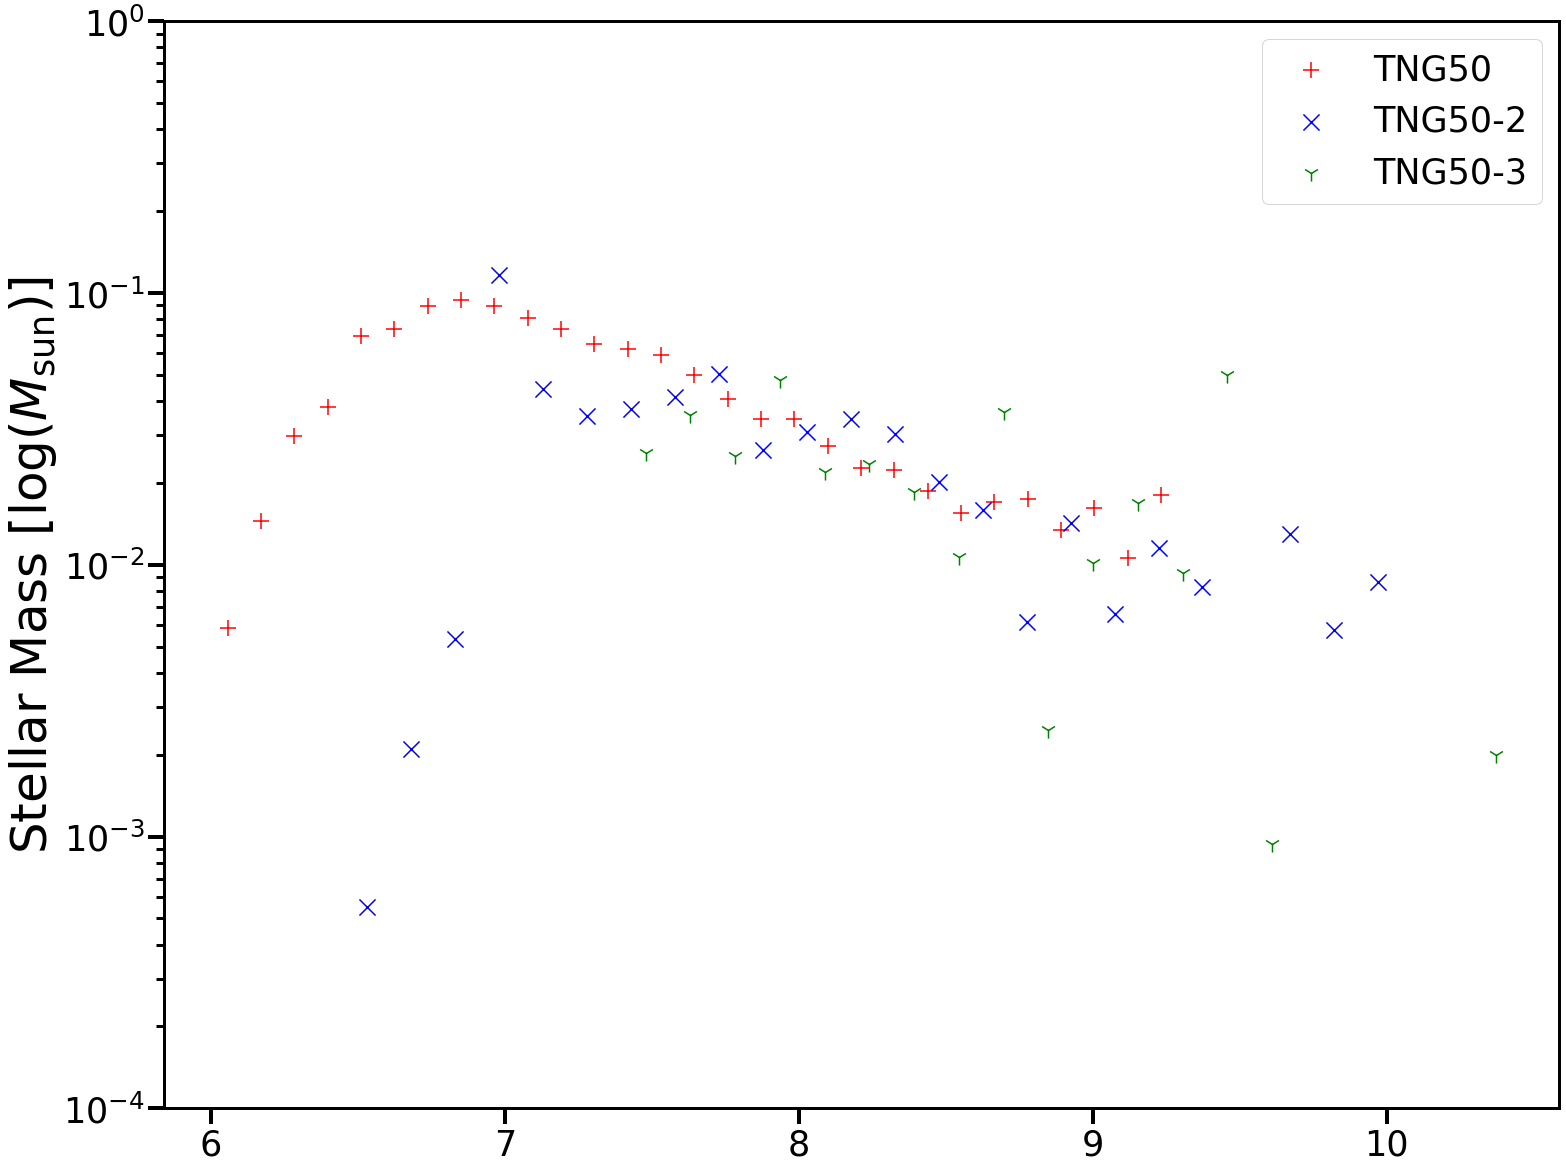

In [86]:
plot_tng_comparison(dfs, halo_prop='StarMass', bins=30, mode='median', y_threshold=1e-4, save=True)